In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Sun Aug 20 21:02:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   46C    P0    71W / 300W |   3829MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Hyperparams

In [4]:
n_mels = 80
n_outputs = 61
n_frames = 400

### Model

In [5]:
from model.model_glowtts_sid import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, enc_hidden_dim=256, out_dim=61, dec_hidden_dim=256)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
print('done')

done


### Load

In [7]:
save_dir = '/data/scpark/save/lips/train08.14-3/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if True:
    step, model, _, optimizer = load(save_dir, 150000, model, None, optimizer)

total 22524548
-rw-rw-r-- 1 scpark scpark         0  8월 20 21:02 events.out.tfevents.1692532956.GPUSVR11
-rw-rw-r-- 1 scpark scpark        40  8월 17 21:03 events.out.tfevents.1692255385.GPUSVR11
-rw-rw-r-- 1 scpark scpark      1723  8월 17 20:44 events.out.tfevents.1692255389.GPUSVR11
-rw-rw-r-- 1 scpark scpark 658999517  8월 17 18:38 save_150000
-rw-rw-r-- 1 scpark scpark 658999517  8월 17 15:57 save_140000
-rw-rw-r-- 1 scpark scpark      5089  8월 17 10:52 events.out.tfevents.1692146006.GPUSVR11
-rw-rw-r-- 1 scpark scpark 658999517  8월 16 23:41 save_130000
-rw-rw-r-- 1 scpark scpark 658999517  8월 16 19:14 save_120000
-rw-rw-r-- 1 scpark scpark 658999517  8월 16 14:50 save_110000
-rw-rw-r-- 1 scpark scpark 658999517  8월 16 10:18 save_100000
-rw-rw-r-- 1 scpark scpark        40  8월 16 09:33 events.out.tfevents.1692145925.GPUSVR11
-rw-rw-r-- 1 scpark scpark        40  8월 16 09:31 events.out.tfevents.1692145792.GPUSVR11
-rw-rw-r-- 1 scpark scpark         0  8월 16 09:29 events.out.tfevents.169

### Dataset

In [8]:
import os
from data.arkit_dataset import LipsDataset, CombinedDataset, CombinedCollate

root_dir = '/data/speech/digital_human/preprocessed/'

def get_files(dir):
    data = []
    files = sorted([os.path.join(dir, file) for file in os.listdir(dir)])
    for file in files:
        if file.endswith('.npy') and 'ARKit' in file:
            data.append(file)
        if os.path.isdir(file):
            data.extend(get_files(os.path.join(dir, file)))
    return data

files = get_files(root_dir)
print(len(files))

train_datasets = []
test_datasets = []

def get_sid(file):
    names = ['No Speaker', 'jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']
    for sid, name in enumerate(names):
        if name in file:
            return sid
    return 0

for file in files:
    sid = get_sid(file)
    print(sid, file)
    dataset = LipsDataset(file, n_mels, n_frames, sid=sid, mel=False)
    if '_10_' in file:
        test_datasets.append(dataset)
    else:
        train_datasets.append(dataset)
print(len(train_datasets), len(test_datasets))

76
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_10_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_11_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_12_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_1_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_2_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_3_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_4_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_5_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_8_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_9_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_10_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_1_iPhone_raw.npy
2

In [9]:
train_loader = torch.utils.data.DataLoader(CombinedDataset(train_datasets), 
                                           num_workers=16, shuffle=True, batch_size=32, collate_fn=CombinedCollate())
test_loader = torch.utils.data.DataLoader(CombinedDataset(test_datasets), 
                                          num_workers=10, shuffle=True, batch_size=10, collate_fn=CombinedCollate())
print('done')

done


In [10]:
from functools import partial
from data.audio import mel_spectrogram
get_mel = partial(mel_spectrogram, n_fft=2048, num_mels=80, sampling_rate=24000, hop_size=800, win_size=2048, fmin=0, fmax=None, center=False, return_spec=False)
    

test : 0 -5.71850061416626
test : 1 -5.799115180969238
test : 2 -5.828712463378906
test : 3 -4.934541702270508
test : 4 -5.878079414367676
test : 5 -5.873643398284912
test : 6 -4.936519622802734
test : 7 -5.567862510681152
test : 8 -5.640262126922607
test : 9 -5.736909866333008
test_loss : -5.591414928436279


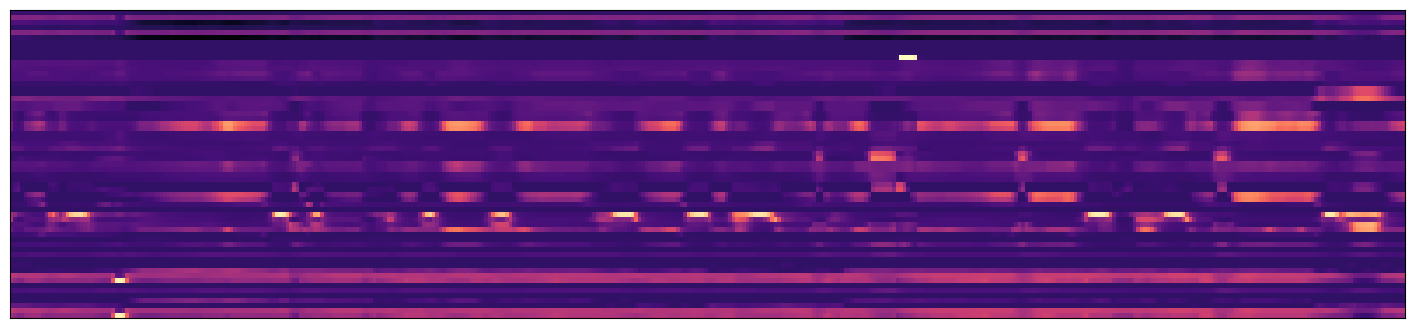

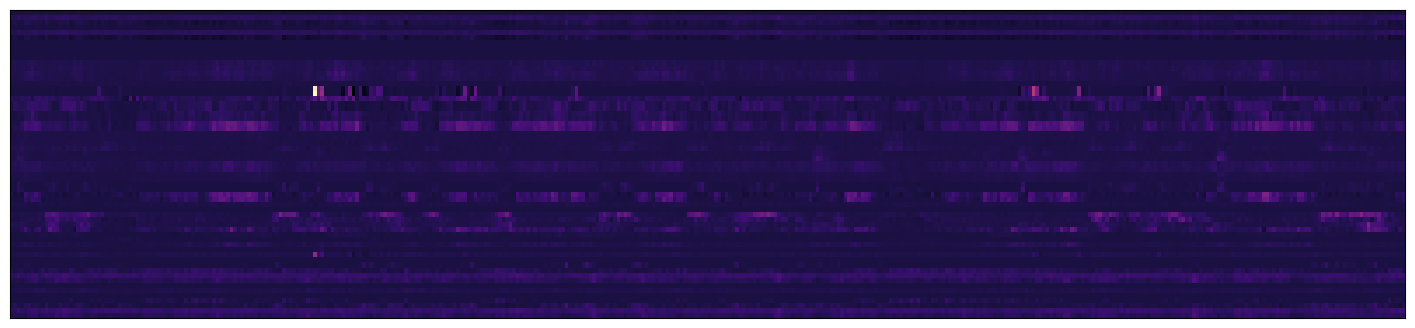

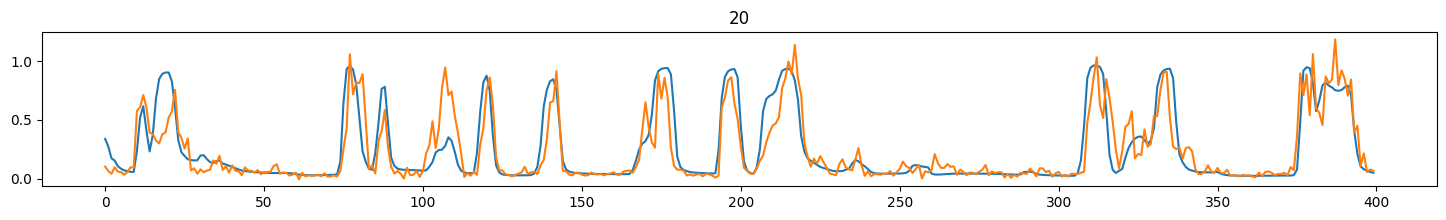

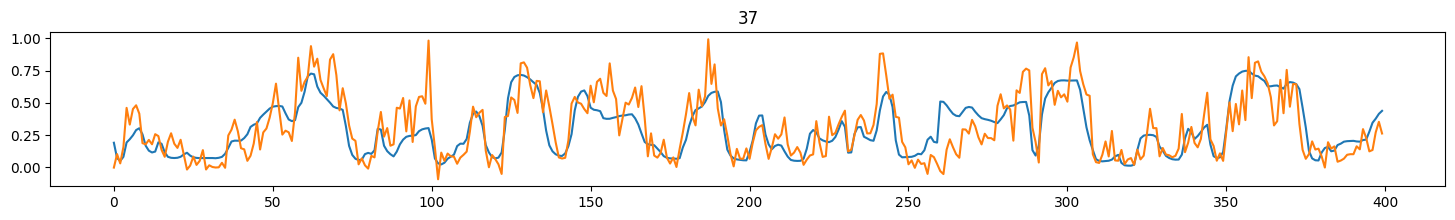

saved /data/scpark/save/lips/train08.14-3/save_150000
150001
loss -5.922471046447754
150001 -5.922471046447754
150002
loss -6.010729789733887
150002 -6.010729789733887
150003
loss -5.906640529632568
150003 -5.906640529632568
150004
loss -5.928539276123047
150004 -5.928539276123047
150005
loss -6.003328800201416
150005 -6.003328800201416
150006
loss -5.927854537963867
150006 -5.927854537963867
150007
loss -6.06440544128418
150007 -6.06440544128418
150008
loss -6.015711784362793
150008 -6.015711784362793
150009
loss -6.0141520500183105
150009 -6.0141520500183105
150010
loss -5.915196895599365
150010 -5.915196895599365
150011
loss -5.8524346351623535
150011 -5.8524346351623535
150012
loss -6.004422664642334
150012 -6.004422664642334
150013
loss -5.815487861633301
150013 -5.815487861633301
150014
loss -5.946198463439941
150014 -5.946198463439941
150015
loss -5.94899845123291
150015 -5.94899845123291
150016
loss -5.975198745727539
150016 -5.975198745727539
150017
loss -5.95146369934082
1500

In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        inputs = get_mel(torch.Tensor(batch['wav'])).to(device)
        targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
        sid = torch.Tensor(batch['sid']).int().to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(inputs, targets, sid)
        
        print(step)
        loss = 0
        for key in outputs.keys():
            if 'loss' in key:
                loss += outputs[key]
                print(key, outputs[key].item())
        if torch.isnan(loss):
            isnan = True
            break
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 1000 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 1000 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                    
                inputs = get_mel(torch.Tensor(batch['wav'])).to(device)
                targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
                sid = torch.Tensor(batch['sid']).int().to(device)

                model.eval()
                with torch.no_grad():
                    outputs = model(inputs, targets, sid)
                    
                loss = 0
                for key in outputs.keys():
                    if 'loss' in key:
                        loss += outputs[key]
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()

            model.eval()
            with torch.no_grad():
                y_pred = model.inference(inputs, sid)

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(y_pred[0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            for i in [20, 37]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(y_pred[0].data.cpu().numpy()[i])
                plt.show()

        if step % 10000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [ ]:
save(save_dir, step, model, None, optimizer)